In [1]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, \
                            precision_score, recall_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords

import os
import nltk

from string import punctuation
from pymystem3 import Mystem
import re

## Построение датафрейма

In [2]:
mystem = Mystem()
garbage_words = stopwords.words('english') + stopwords.words('russian')

def BuildDataFrame(cur_folder, doc_types, file_names, doc_texts, name=''):
    files = os.listdir()
    cur_name = name[:]
    if len(cur_name) != 0:
        cur_name += '-'
    cur_name += cur_folder
    if 'text_layer' in files:
        files.remove('text_layer')
        print('in', cur_name)
        
    folders = [file for file in files if '.' not in file]
    
    for folder in folders:
        os.chdir(folder)
        BuildDataFrame(folder, doc_types, file_names, doc_texts, cur_name)
        os.chdir('..')
    if len(folders) == 0:
        for file in files:
            text_layer = ''
            if 'text_layer' in os.listdir():
                try:
                    with open('./text_layer/' + file.split('.')[0] + '.txt') as f:
                        text_layer = f.read()
                except:
                    NOT_FOUND.append((file, cur_name))
            if len(text_layer) > 0:
                doc_texts.append(text_layer)
                doc_types.append(cur_name)
                file_names.append(file)
        

Документы для тестового и тренировочного сетов распределены по папкам, причем тип документа определяется тем, по какому пути он лежит, например, если документ лежит в папке `ad/invoice/first`, то его тип: `ad-invoice-first`.

Для формирования датафрейма пройдемся по папкам с документами и соберем все предварительно снятые текстовые слои документов вместе с типами этих документов.

In [3]:
# build dataframe
NOT_FOUND = []
doc_types, file_names, doc_texts = [], [], []
dataset_path = 'for training'
os.chdir(dataset_path)
BuildDataFrame('', doc_types, file_names, doc_texts)
os.chdir('..')
df = pd.DataFrame({'file_name': file_names, 'doc_type': doc_types, 'doc_text' : doc_texts})

in ad-error
in ad-invoice-first
in ad-invoice-multi
in ad-statement-first
in ad-statement-multi
in ad-upd-first
in ad-upd-multi
in ad-waybill-first
in ad-waybill-multi
in rfq-AOG
in rfq-CRITICAL
in rfq-Routine
in rfq-Spam
in sec-error
in sec-Изменение контроля
in sec-Кросс-дефолт
in sec-Обозначение прав дочерних компаний
in sec-Оговорки о коллективных действиях
in sec-Ограничение деятельности
in sec-Ограничение задолженности
in sec-Ограничение задолженности дочерних компаний
in sec-Ограничение по инвестициям
in sec-Ограничение по наслоению долговых обязательств по рангам
in sec-Ограничение по платежам
in sec-Ограничение по платежам в отношении дочерних компаний
in sec-Ограничение по предоставлению залога
in sec-Ограничение по продаже активов
in sec-Ограничение по продаже активов с обратной арендой
in sec-Ограничение по слиянию
in sec-Ограничение по транзакциям с аффилированными лицами
in sec-Случаи дефолта
in sec-Триггер рейтингов
in sec-Условие приостановки действия ковенантов
in sec-

In [4]:
# part for checking files that weren't found
ext = [x[0].split('.')[-1] for x in NOT_FOUND]
print(set(ext))
formated_not_found = ['file {} at {} not found'.format(x[0], x[1]) for x in NOT_FOUND if '' in x[0].split('.')[-1].lower()]
print(len(formated_not_found))
print('\n'.join(formated_not_found))

{'JPEG', 'pdf', 'msg', 'jpg', 'PDF'}
49
file 06014769-9ae4-458d-a7cb-8ade56355dd6.pdf at ad-error not found
file 1012b487-da5b-43b3-91b5-1862e8b07c5a.pdf at ad-error not found
file 10f6b3f1-bcaa-49c6-af90-4493d6d50cbd.pdf at ad-error not found
file 19596038-1690-4aa0-84aa-162381f70581.pdf at ad-error not found
file 1e9ba652-ca81-4eec-9208-d0dfad11469b.pdf at ad-error not found
file 1f6f9a23-d9c4-4ed8-be3b-89afd4c77568.pdf at ad-error not found
file 25cbeedc-2612-4784-86de-0e139945707b.pdf at ad-error not found
file 29dcc2e1-9a68-49c1-9d43-741cf491d5dc.pdf at ad-error not found
file 2a4d3482-25d4-403b-9a0d-4b41841d44b3.pdf at ad-error not found
file 369310e4-850d-46bb-a756-151af523810a.pdf at ad-error not found
file 41aebe14-3183-46a1-b4fd-3a1513b787c7.pdf at ad-error not found
file 4889bca2-01e1-4c31-bacb-0632f36878c8.pdf at ad-error not found
file 4a753c6d-80d7-4cc9-b0e8-0192b82f0377.PDF at ad-error not found
file 51a0488a-44cd-4956-b749-998de144527b.pdf at ad-error not found
file 544

Проведем очистку текста от мусорных слов и пунктуации.

In [5]:
def ClearText(text, garbage_words):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'[().,:-]', '', text).replace('\n', ' ')
    tokens = text.lower().split()
    tokens = [token for token in tokens if token not in garbage_words and token != ' ' and token.strip() not in punctuation]
    text = ' '.join(tokens)
    return text

In [6]:
for i in range(len(df['doc_text'])):
    df['doc_text'][i] = ClearText(df['doc_text'][i], garbage_words)
df = df.rename(columns={'doc_type' : 'target', 'doc_text' : 'X'})

Посмотрим на процентное соотношение типов документов в датафрейме

In [7]:
types_list = list(set(df['target']))
types_fra = [len(df[df['target']  == tp]) / len(df) for tp in types_list]
cnt = [len(df[df['target']  == tp]) for tp in types_list]
stat = pd.DataFrame({'target': types_list, 'percentage' : types_fra, 'count' : cnt}).sort_values('percentage')
stat

,target,percentage
27,sec-Ограничение по инвестициям,0.000041
21,sec-Ограничение по наслоению долговых обязател...,0.000246
1,sec-Условие приостановки действия ковенантов,0.000451
11,sec-Ограничение по платежам в отношении дочерн...,0.000451
17,sec-Ограничение по платежам,0.000492
5,sec-Ограничение задолженности дочерних компаний,0.000534
6,sec-Обозначение прав дочерних компаний,0.000534
3,sec-Ограничение по продаже активов,0.000575
10,sec-Ограничение задолженности,0.000575
12,sec-Ограничение по продаже активов с обратной ...,0.000575


Видим, что есть очень малопредставленыые классы документов, да и в целом соотношение у классов разное.

Это нужно будет учесть при дальнейшем обучении модели.

Разобъем датасет на тренировочную и тестовую выборки так, чтобы в каждой подвыборке оказалась равная пропорция документов каждого класса.

In [8]:
def SplitTrainSample(dataframe, fraction=0.7):
    types = set(dataframe['target'])
    dataframes = [dataframe[dataframe['target'] == doc_type] for doc_type in types]
    splited = [np.split(df.sample(frac=1), [int(fraction * len(df))]) for df in dataframes]
    test = [df[0] for df in splited]
    train = [df[1] for df in splited]
    return pd.concat(train).sample(frac=1), pd.concat(test).sample(frac=1)


def CreateVectorizer(ngram_range, max_features):
    return CountVectorizer(analyzer="word",
                           #min_df=5,
                           #max_df=0.7,
                           ngram_range=ngram_range,
                           max_features=max_features
                         )

In [84]:
train, test = SplitTrainSample(df, fraction=0.7)
X_train, Y_train = train['X'], train['target']
vectorizer = CreateVectorizer((1, 3), 50000)
X_train = vectorizer.fit_transform(X_train)

Проведем несколько кросс валидаций, чтобы выявить значения параметров, при которых классификатор дает наиболее хорошие результаты.

Мы видели, что классы документов несбалансированы, поэтому установим параметр $\text{class_weight}=\text{'balanced'}$, чтобы модель случайного леса скоректировала веса.

Запустим несколько кросс валидаций по параметрам: 
* n_estimators
* max_features 
* min_samples_split
* min_samples_leaf
* bootstrap

На первом этапе с помощью случайной валидации выделим диапазоны значений параметров, которые дают наилучшие результаты по точности классификатора.

Далее будем отсеивать диапазоны  параметров, которые дают плохие результаты.

## Первый раунд рандомизированной кросс валидации. 
Отсеим диапазоны значений параметров, которые дают плохие результаты.

In [104]:
n_estimators = [int(x) for x in np.linspace(start=100, stop=400, num=12)]
max_features = [0.025, 0.04, 0.06, 'sqrt']
min_samples_split = [int(x) for x in np.linspace(start=5, stop=55, num=11)]
min_samples_leaf = [int(x) for x in np.linspace(start=1, stop=40, num=9)]
bootstrap = [True, False]

param_dist = {
    'n_estimators' : n_estimators,
    'max_features' : max_features,
    'min_samples_split' : min_samples_split,
    'min_samples_leaf' : min_samples_leaf,
    'bootstrap' : bootstrap,
}
for key in param_dist.keys():
    print('{}: {}'.format(key, param_dist[key]))

n_estimators: [100, 127, 154, 181, 209, 236, 263, 290, 318, 345, 372, 400]
max_features: [0.025, 0.04, 0.06, 'sqrt']
min_samples_split: [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
min_samples_leaf: [1, 5, 10, 15, 20, 25, 30, 35, 40]
bootstrap: [True, False]


In [105]:
def RunRandomizedCrossValidation(base_rf, params, cv, n_iters):
    rs = RandomizedSearchCV(base_rf,
                        params,
                        n_iter=n_iters,
                        cv=cv,
                        verbose=3,
                        n_jobs=1,
                        random_state=0,
                        scoring='f1_weighted')
    rs.fit(X_train, Y_train)
    return rs

In [106]:
rs1 = RunRandomizedCrossValidation(RandomForestClassifier(class_weight='balanced'), param_dist, 3, 100)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  UserWarning,


[CV 1/3] END bootstrap=False, max_features=0.04, min_samples_leaf=20, min_samples_split=40, n_estimators=154;, score=0.868 total time=  15.7s
[CV 2/3] END bootstrap=False, max_features=0.04, min_samples_leaf=20, min_samples_split=40, n_estimators=154;, score=0.861 total time=  15.9s
[CV 3/3] END bootstrap=False, max_features=0.04, min_samples_leaf=20, min_samples_split=40, n_estimators=154;, score=0.871 total time=  15.4s
[CV 1/3] END bootstrap=True, max_features=0.025, min_samples_leaf=5, min_samples_split=10, n_estimators=372;, score=0.882 total time=  44.0s
[CV 2/3] END bootstrap=True, max_features=0.025, min_samples_leaf=5, min_samples_split=10, n_estimators=372;, score=0.882 total time=  45.2s
[CV 3/3] END bootstrap=True, max_features=0.025, min_samples_leaf=5, min_samples_split=10, n_estimators=372;, score=0.886 total time=  41.8s
[CV 1/3] END bootstrap=False, max_features=0.04, min_samples_leaf=5, min_samples_split=20, n_estimators=209;, score=0.882 total time=  33.2s
[CV 2/3] E

[CV 2/3] END bootstrap=False, max_features=0.025, min_samples_leaf=5, min_samples_split=30, n_estimators=400;, score=0.879 total time=  41.4s
[CV 3/3] END bootstrap=False, max_features=0.025, min_samples_leaf=5, min_samples_split=30, n_estimators=400;, score=0.880 total time=  40.2s
[CV 1/3] END bootstrap=False, max_features=0.025, min_samples_leaf=25, min_samples_split=55, n_estimators=100;, score=0.857 total time=   6.2s
[CV 2/3] END bootstrap=False, max_features=0.025, min_samples_leaf=25, min_samples_split=55, n_estimators=100;, score=0.855 total time=   6.2s
[CV 3/3] END bootstrap=False, max_features=0.025, min_samples_leaf=25, min_samples_split=55, n_estimators=100;, score=0.857 total time=   6.0s
[CV 1/3] END bootstrap=False, max_features=sqrt, min_samples_leaf=40, min_samples_split=25, n_estimators=290;, score=0.805 total time=   5.3s
[CV 2/3] END bootstrap=False, max_features=sqrt, min_samples_leaf=40, min_samples_split=25, n_estimators=290;, score=0.815 total time=   5.0s
[CV

[CV 3/3] END bootstrap=False, max_features=sqrt, min_samples_leaf=30, min_samples_split=30, n_estimators=263;, score=0.811 total time=   5.6s
[CV 1/3] END bootstrap=True, max_features=0.06, min_samples_leaf=40, min_samples_split=15, n_estimators=345;, score=0.826 total time=  25.8s
[CV 2/3] END bootstrap=True, max_features=0.06, min_samples_leaf=40, min_samples_split=15, n_estimators=345;, score=0.821 total time=  25.1s
[CV 3/3] END bootstrap=True, max_features=0.06, min_samples_leaf=40, min_samples_split=15, n_estimators=345;, score=0.828 total time=  24.0s
[CV 1/3] END bootstrap=False, max_features=sqrt, min_samples_leaf=25, min_samples_split=35, n_estimators=127;, score=0.815 total time=   2.8s
[CV 2/3] END bootstrap=False, max_features=sqrt, min_samples_leaf=25, min_samples_split=35, n_estimators=127;, score=0.838 total time=   2.8s
[CV 3/3] END bootstrap=False, max_features=sqrt, min_samples_leaf=25, min_samples_split=35, n_estimators=127;, score=0.834 total time=   2.9s
[CV 1/3] 

[CV 1/3] END bootstrap=False, max_features=0.06, min_samples_leaf=15, min_samples_split=15, n_estimators=209;, score=0.875 total time=  31.0s
[CV 2/3] END bootstrap=False, max_features=0.06, min_samples_leaf=15, min_samples_split=15, n_estimators=209;, score=0.869 total time=  31.1s
[CV 3/3] END bootstrap=False, max_features=0.06, min_samples_leaf=15, min_samples_split=15, n_estimators=209;, score=0.876 total time=  30.5s
[CV 1/3] END bootstrap=False, max_features=0.025, min_samples_leaf=30, min_samples_split=50, n_estimators=290;, score=0.849 total time=  16.4s
[CV 2/3] END bootstrap=False, max_features=0.025, min_samples_leaf=30, min_samples_split=50, n_estimators=290;, score=0.847 total time=  16.6s
[CV 3/3] END bootstrap=False, max_features=0.025, min_samples_leaf=30, min_samples_split=50, n_estimators=290;, score=0.839 total time=  16.2s
[CV 1/3] END bootstrap=True, max_features=0.06, min_samples_leaf=5, min_samples_split=25, n_estimators=290;, score=0.889 total time=  47.9s
[CV 2

[CV 3/3] END bootstrap=True, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=400;, score=0.864 total time=  14.4s
[CV 1/3] END bootstrap=False, max_features=sqrt, min_samples_leaf=35, min_samples_split=30, n_estimators=318;, score=0.812 total time=   6.1s
[CV 2/3] END bootstrap=False, max_features=sqrt, min_samples_leaf=35, min_samples_split=30, n_estimators=318;, score=0.828 total time=   6.0s
[CV 3/3] END bootstrap=False, max_features=sqrt, min_samples_leaf=35, min_samples_split=30, n_estimators=318;, score=0.811 total time=   6.1s
[CV 1/3] END bootstrap=False, max_features=0.04, min_samples_leaf=15, min_samples_split=20, n_estimators=127;, score=0.873 total time=  14.3s
[CV 2/3] END bootstrap=False, max_features=0.04, min_samples_leaf=15, min_samples_split=20, n_estimators=127;, score=0.865 total time=  14.1s
[CV 3/3] END bootstrap=False, max_features=0.04, min_samples_leaf=15, min_samples_split=20, n_estimators=127;, score=0.876 total time=  13.7s
[CV 1/3]

[CV 1/3] END bootstrap=True, max_features=0.025, min_samples_leaf=15, min_samples_split=40, n_estimators=290;, score=0.865 total time=  17.4s
[CV 2/3] END bootstrap=True, max_features=0.025, min_samples_leaf=15, min_samples_split=40, n_estimators=290;, score=0.859 total time=  17.7s
[CV 3/3] END bootstrap=True, max_features=0.025, min_samples_leaf=15, min_samples_split=40, n_estimators=290;, score=0.859 total time=  17.7s
[CV 1/3] END bootstrap=True, max_features=0.04, min_samples_leaf=35, min_samples_split=25, n_estimators=290;, score=0.821 total time=  17.1s
[CV 2/3] END bootstrap=True, max_features=0.04, min_samples_leaf=35, min_samples_split=25, n_estimators=290;, score=0.830 total time=  17.0s
[CV 3/3] END bootstrap=True, max_features=0.04, min_samples_leaf=35, min_samples_split=25, n_estimators=290;, score=0.826 total time=  16.3s
[CV 1/3] END bootstrap=False, max_features=0.04, min_samples_leaf=10, min_samples_split=40, n_estimators=236;, score=0.883 total time=  26.3s
[CV 2/3] 

Сформируем датафрейм для того, чтобы было удобнее анализировать результаты кросс валидации.

Отранжируем строки в датафрейме по убыванию точности классификатора.

In [107]:
def GetResultsDataFrame(searcher):
    searcher_df = pd.DataFrame(searcher.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
    searcher_df = searcher_df.drop([
        'mean_fit_time',
        'std_fit_time',
        'std_score_time',
        'mean_score_time',
        'params',
        'split0_test_score',
        'split1_test_score',
        'split2_test_score',
        'std_test_score'
    ], axis=1)
    return searcher_df

In [108]:
rs1_df = GetResultsDataFrame(rs1)
rs1_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_bootstrap,mean_test_score,rank_test_score
0,400,15,1,0.04,False,0.895832,1
1,100,40,1,0.04,False,0.894389,2
2,236,55,1,0.06,True,0.893411,3
3,318,20,1,0.025,True,0.891713,4
4,290,25,5,0.06,True,0.889377,5
5,318,30,5,0.06,False,0.886612,6
6,236,55,5,0.06,True,0.886414,7
7,263,35,5,0.04,False,0.885092,8
8,372,10,5,0.025,True,0.883591,9
9,209,20,5,0.04,False,0.883579,10


Построим графики, которые покажут, какое среднее значение метрики `f1-weighted` было у классификатора при каждом значении параметра

In [109]:
def ShowGraphics(param_dist, rs_df, min_scoring=0.4):
    colors = ['lightgrey', 'coral', 'lightgreen', 'wheat', 'lightpink', 
                'skyblue', 'forestgreen', 'maroon', 'olivedrab']
    params = ['param_' + x for x in list(param_dist.keys())]
    ncols, nrows = 2, len(params) // 2 + len(params) % 2
    fig, axs = plt.subplots(ncols=ncols, nrows=max(2, nrows))
    sns.set(style="whitegrid", color_codes=True, font_scale=2)
    fig.set_size_inches(35, 30)

    for ind in range(len(params)):
        i = ind // ncols
        j = ind % ncols
        sns.barplot(x=params[ind], y='mean_test_score', data=rs_df, ax=axs[i, j], color=colors[ind])
        axs[i, j].set_ylim([min_scoring, 1])
        axs[i, j].set_title(label=params[ind], size=30, weight='bold')
    plt.show()

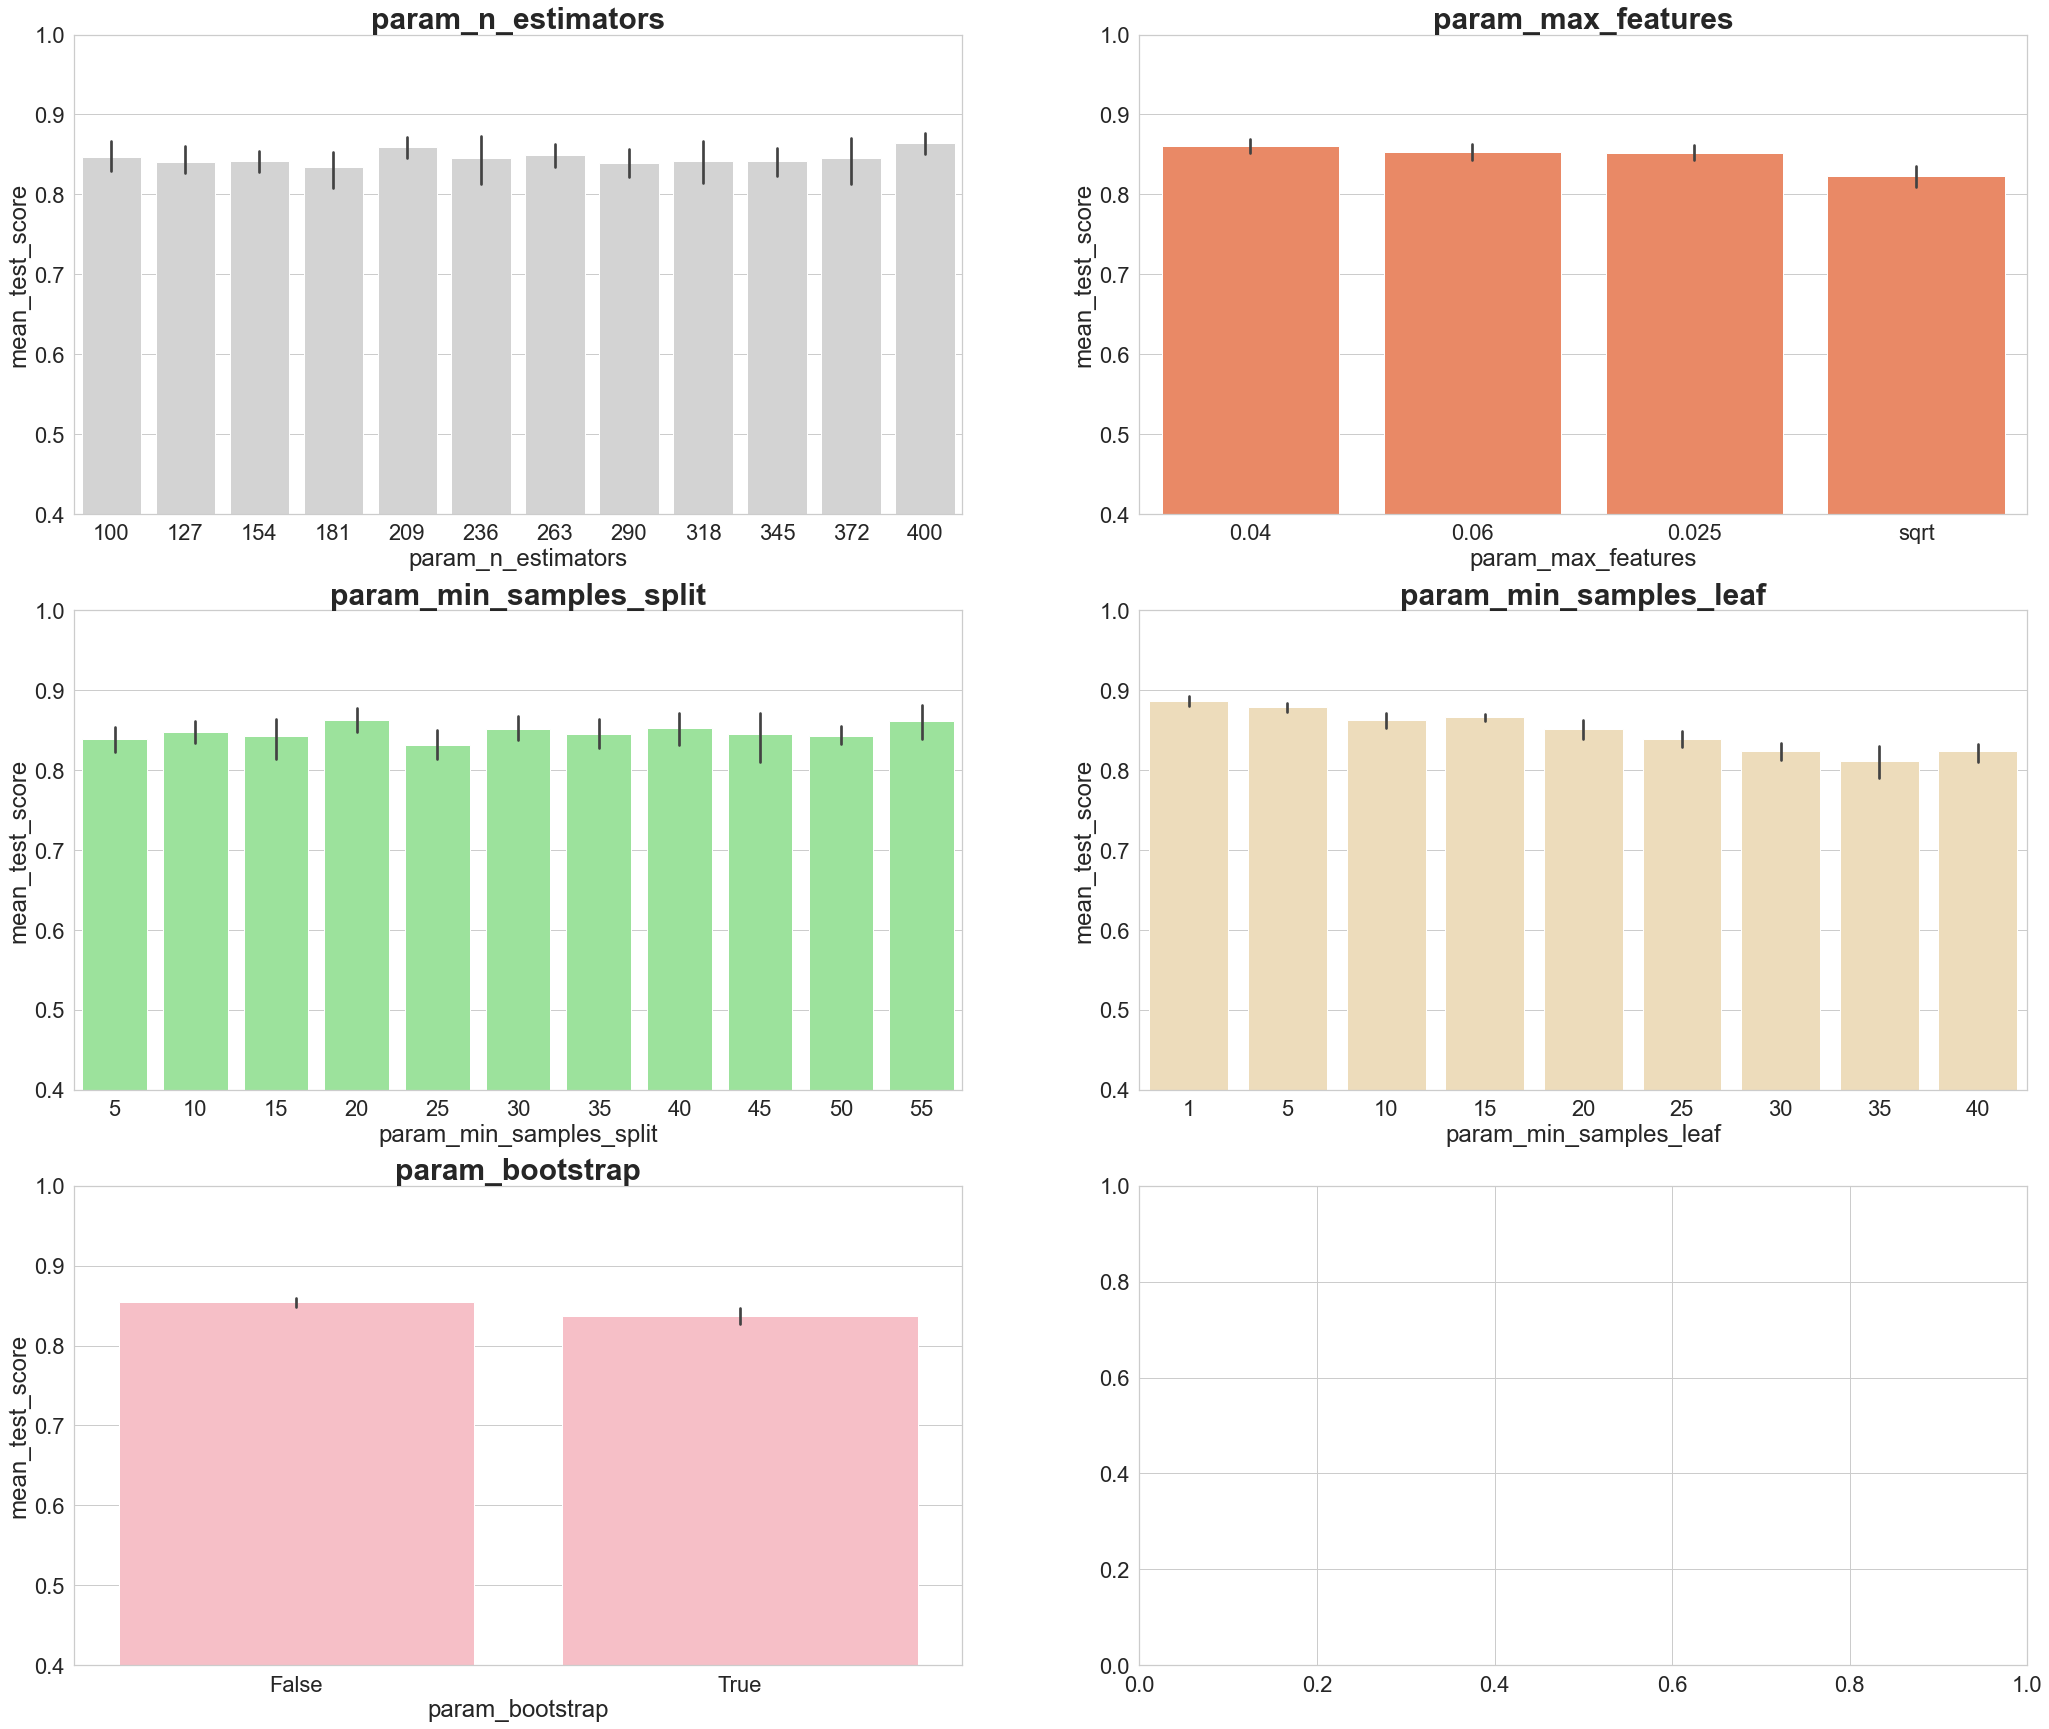

In [110]:
ShowGraphics(param_dist, rs1_df, 0.8)

=== text ===

In [111]:
def ShowStatistics(model_, vectorizer_, to_show_model=True):
    prediction = model_.predict(vectorizer_.transform(test['X']))
    if to_show_model:
        print('model:', model_)
        print('vectorizer:', vectorizer_)
    print('Rows in test set: {}'.format(len(test)))
    print('Accuracy score: {}%'.format(round(100 * accuracy_score(test['target'], prediction), 2)))
    print('Precision score: {}%'.format(round(100 * precision_score(test['target'], prediction, average='weighted'), 2)))
    print('Recall score: {}%'.format(round(100 * recall_score(test['target'], prediction, average='weighted'), 2)))
    print(classification_report(test['target'], prediction))

    
def ShowConfusionMatrix(model_, vectorizer_):
    prediction = model_.predict(vectorizer_.transform(test['X']))
    cm = confusion_matrix(test['target'], prediction)
    class_names = sorted(list(set(df['target'])))
    disp = ConfusionMatrixDisplay.from_estimator(
        rs1.best_estimator_,
        vectorizer.transform(train['X']),
        train['target'],
        display_labels=class_names,
        cmap=plt.cm.Blues,
    )
    disp.ax_.set_title("Confusion matrix, without normalization")
    disp.figure_.set_size_inches(70, 30)
    plt.show()

In [112]:
ShowStatistics(rs1.best_estimator_, vectorizer)

model: RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       max_features=0.04, min_samples_split=15,
                       n_estimators=400)
vectorizer: CountVectorizer(max_features=50000, ngram_range=(1, 3))
Rows in test set: 17041
Accuracy score: 89.99%
Precision score: 90.65%


C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall score: 89.99%
                                                              precision    recall  f1-score   support

                                            ad-invoice-first       0.94      0.92      0.93      2931
                                            ad-invoice-multi       0.85      0.76      0.80       359
                                          ad-statement-first       0.98      0.99      0.98      3929
                                          ad-statement-multi       0.93      0.87      0.90       524
                                                ad-upd-first       0.90      0.96      0.93      2488
                                                ad-upd-multi       0.89      0.86      0.87       520
                                            ad-waybill-first       0.96      0.96      0.96       985
                                            ad-waybill-multi       0.96      0.77      0.86       139
                                                     rfq-AOG

C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Так же посмотрим на матрицу ошибки

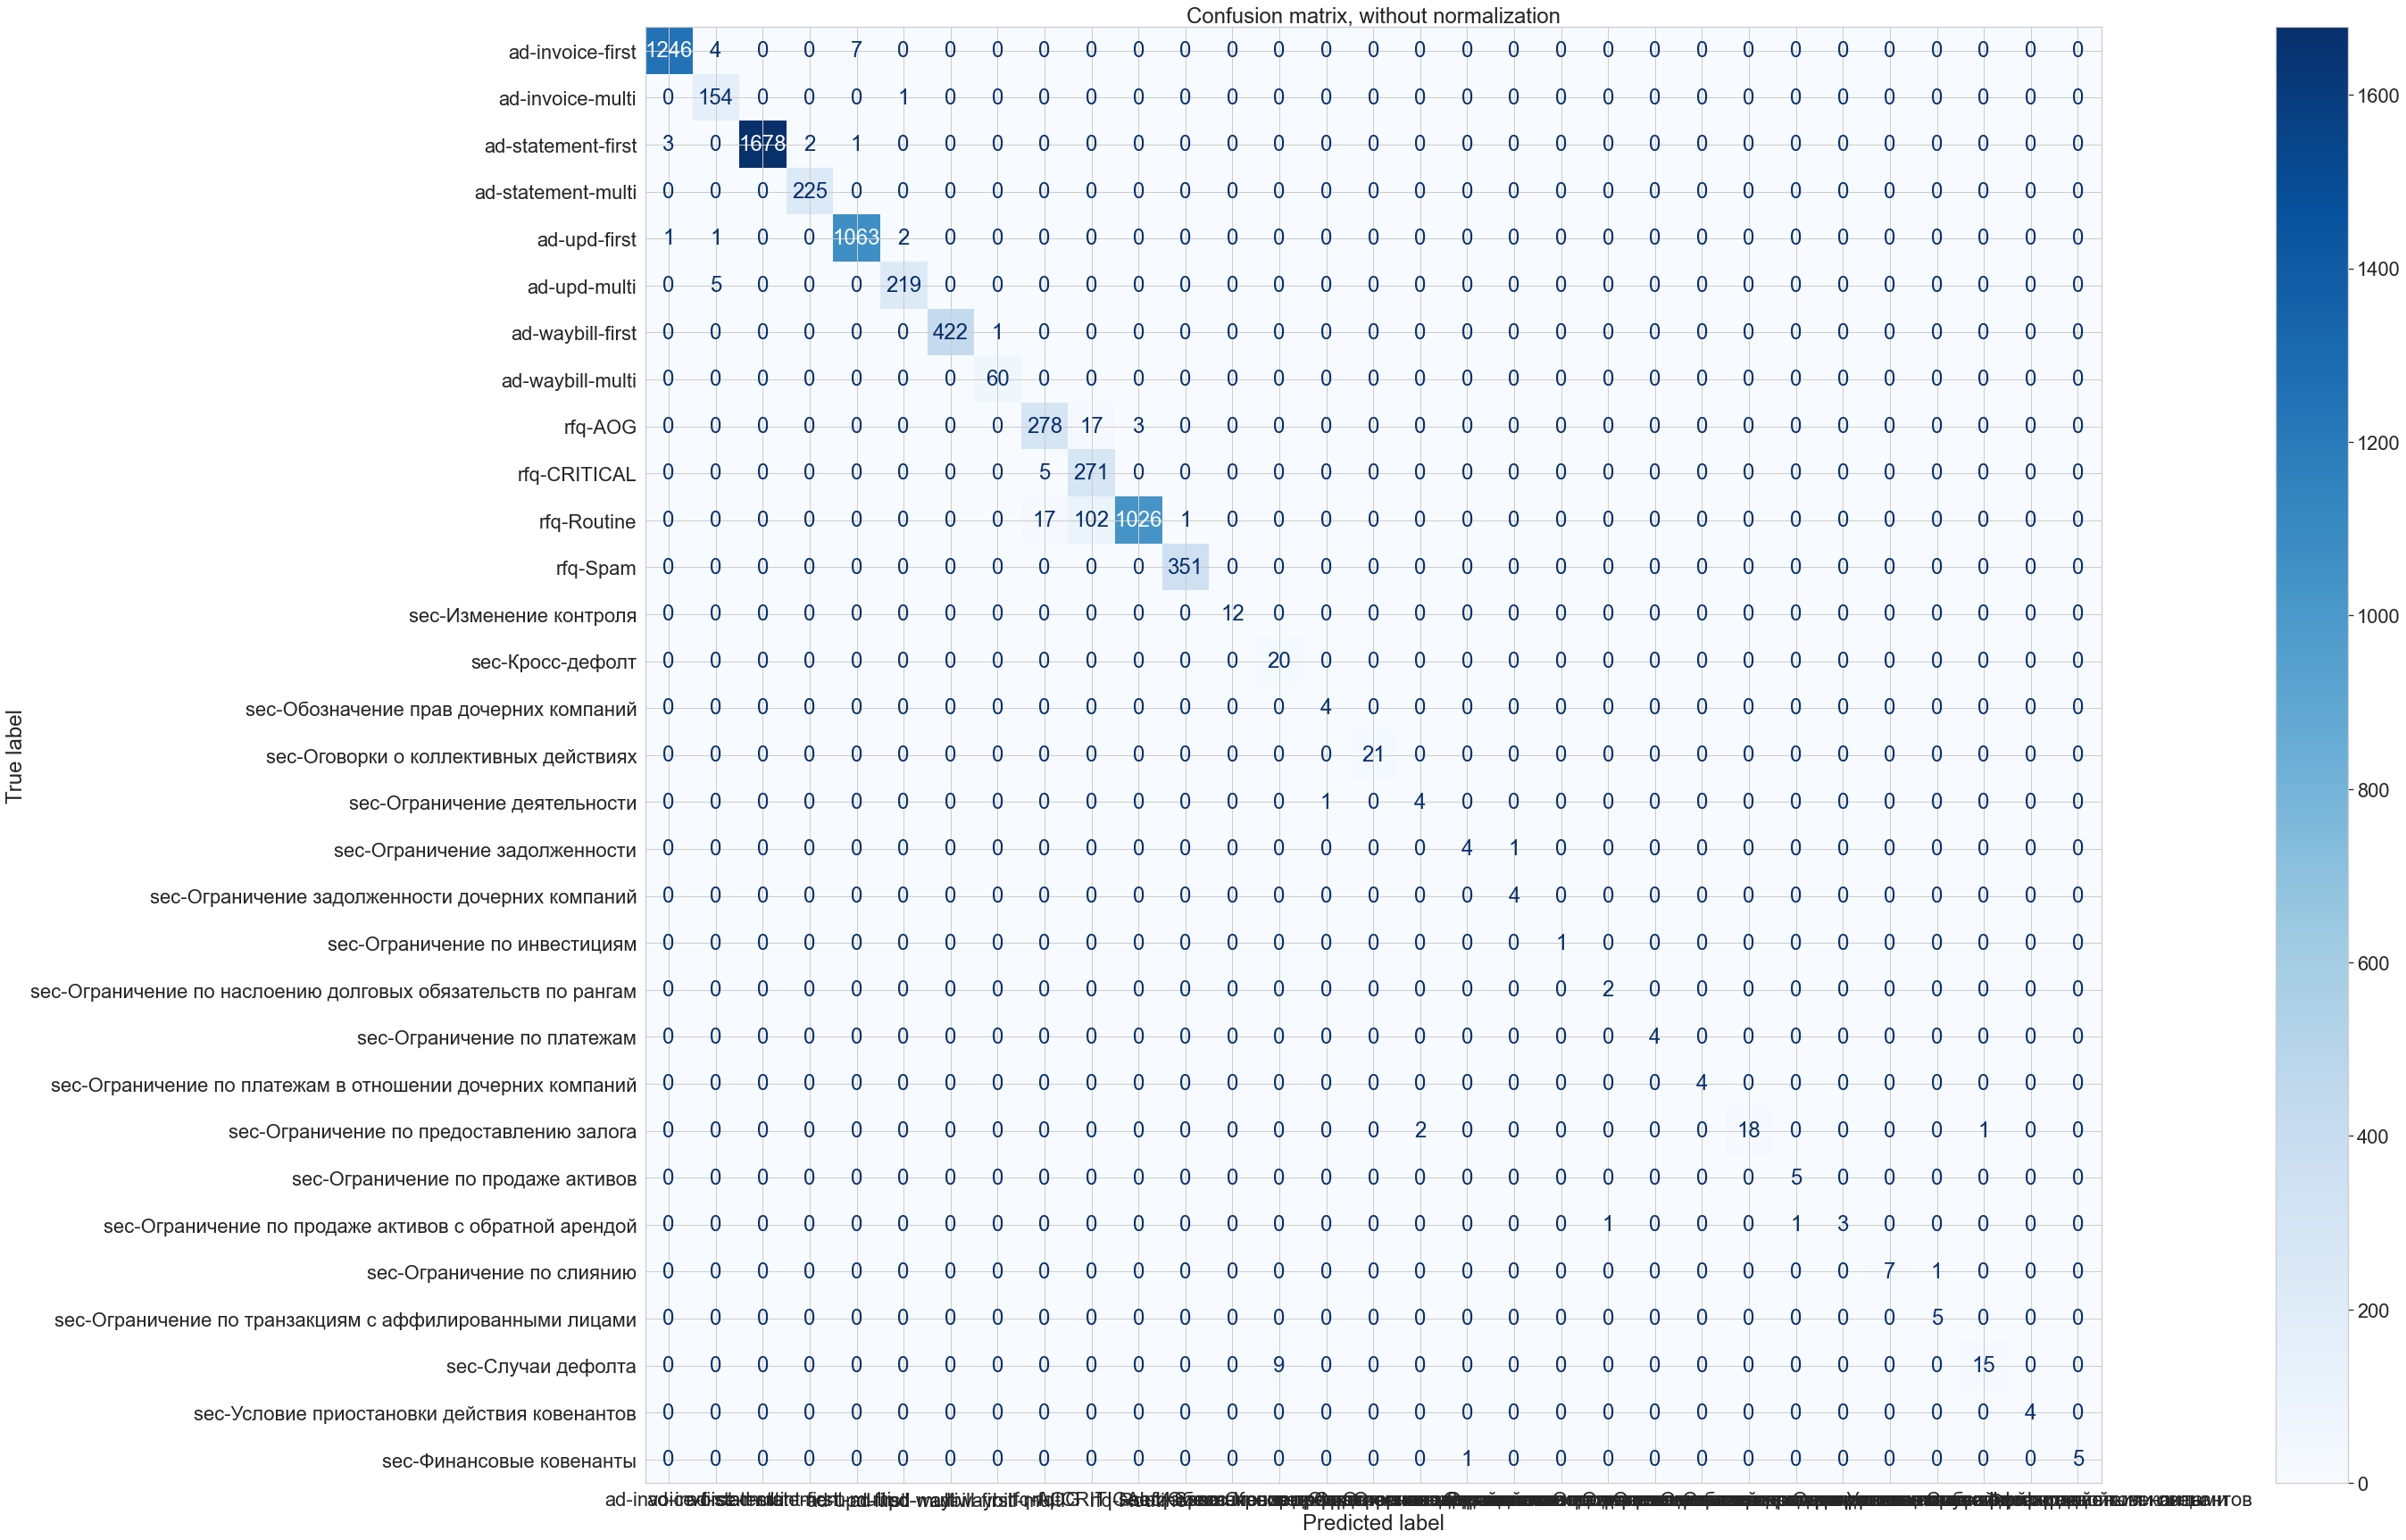

In [113]:
ShowConfusionMatrix(rs1.best_estimator_, vectorizer)

## Второй раунд рандомизированной кросс валидации. 
Отсеим значения параметров, которые дают плохие результаты и среди оставшихся параметров определим диапазоны, в которых могут находиться оптимальные значения параметров.

In [125]:
n_estimators = [int(x) for x in np.linspace(start=100, stop=350, num=19)]
min_samples_split = [int(x) for x in np.linspace(start=5, stop=55, num=11)]
max_features = [0.04, 0.025, 0.06]

param_dist = {
    'n_estimators' : n_estimators,
    'min_samples_split' : min_samples_split,
    'max_features' : max_features,
}
for key in param_dist.keys():
    print('{}: {}'.format(key, param_dist[key]))

n_estimators: [100, 113, 127, 141, 155, 169, 183, 197, 211, 225, 238, 252, 266, 280, 294, 308, 322, 336, 350]
min_samples_split: [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
max_features: [0.04, 0.025, 0.06]


In [115]:
rs2 = RunRandomizedCrossValidation(RandomForestClassifier(min_samples_leaf=1,
                                                          class_weight='balanced',
                                                          bootstrap=False), param_dist, 3, 100)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  UserWarning,


[CV 1/3] END max_features=0.06, min_samples_split=30, n_estimators=100;, score=0.896 total time=  27.2s
[CV 2/3] END max_features=0.06, min_samples_split=30, n_estimators=100;, score=0.894 total time=  25.7s
[CV 3/3] END max_features=0.06, min_samples_split=30, n_estimators=100;, score=0.898 total time=  25.3s
[CV 1/3] END max_features=0.06, min_samples_split=35, n_estimators=336;, score=0.896 total time= 1.5min
[CV 2/3] END max_features=0.06, min_samples_split=35, n_estimators=336;, score=0.896 total time= 1.4min
[CV 3/3] END max_features=0.06, min_samples_split=35, n_estimators=336;, score=0.897 total time= 1.4min
[CV 1/3] END max_features=0.04, min_samples_split=30, n_estimators=211;, score=0.890 total time=  43.6s
[CV 2/3] END max_features=0.04, min_samples_split=30, n_estimators=211;, score=0.895 total time=  41.5s
[CV 3/3] END max_features=0.04, min_samples_split=30, n_estimators=211;, score=0.897 total time=  40.2s
[CV 1/3] END max_features=0.025, min_samples_split=10, n_estimat

[CV 2/3] END max_features=0.04, min_samples_split=25, n_estimators=225;, score=0.895 total time=  45.0s
[CV 3/3] END max_features=0.04, min_samples_split=25, n_estimators=225;, score=0.896 total time=  44.5s
[CV 1/3] END max_features=0.06, min_samples_split=35, n_estimators=294;, score=0.896 total time= 1.3min
[CV 2/3] END max_features=0.06, min_samples_split=35, n_estimators=294;, score=0.895 total time= 1.3min
[CV 3/3] END max_features=0.06, min_samples_split=35, n_estimators=294;, score=0.896 total time= 1.2min
[CV 1/3] END max_features=0.04, min_samples_split=55, n_estimators=308;, score=0.896 total time=  58.2s
[CV 2/3] END max_features=0.04, min_samples_split=55, n_estimators=308;, score=0.894 total time=  54.1s
[CV 3/3] END max_features=0.04, min_samples_split=55, n_estimators=308;, score=0.894 total time=  52.3s
[CV 1/3] END max_features=0.025, min_samples_split=10, n_estimators=308;, score=0.888 total time=  59.8s
[CV 2/3] END max_features=0.025, min_samples_split=10, n_estima

[CV 3/3] END max_features=0.04, min_samples_split=55, n_estimators=100;, score=0.894 total time=  17.1s
[CV 1/3] END max_features=0.04, min_samples_split=5, n_estimators=294;, score=0.896 total time= 1.5min
[CV 2/3] END max_features=0.04, min_samples_split=5, n_estimators=294;, score=0.899 total time= 1.5min
[CV 3/3] END max_features=0.04, min_samples_split=5, n_estimators=294;, score=0.899 total time= 1.4min
[CV 1/3] END max_features=0.06, min_samples_split=55, n_estimators=350;, score=0.896 total time= 1.5min
[CV 2/3] END max_features=0.06, min_samples_split=55, n_estimators=350;, score=0.893 total time= 1.4min
[CV 3/3] END max_features=0.06, min_samples_split=55, n_estimators=350;, score=0.896 total time= 1.3min
[CV 1/3] END max_features=0.025, min_samples_split=10, n_estimators=113;, score=0.887 total time=  21.8s
[CV 2/3] END max_features=0.025, min_samples_split=10, n_estimators=113;, score=0.898 total time=  21.3s
[CV 3/3] END max_features=0.025, min_samples_split=10, n_estimato

[CV 1/3] END max_features=0.06, min_samples_split=55, n_estimators=266;, score=0.898 total time= 1.1min
[CV 2/3] END max_features=0.06, min_samples_split=55, n_estimators=266;, score=0.895 total time= 1.0min
[CV 3/3] END max_features=0.06, min_samples_split=55, n_estimators=266;, score=0.897 total time= 1.0min
[CV 1/3] END max_features=0.06, min_samples_split=30, n_estimators=266;, score=0.895 total time= 1.2min
[CV 2/3] END max_features=0.06, min_samples_split=30, n_estimators=266;, score=0.895 total time= 1.1min
[CV 3/3] END max_features=0.06, min_samples_split=30, n_estimators=266;, score=0.897 total time= 1.1min
[CV 1/3] END max_features=0.04, min_samples_split=10, n_estimators=350;, score=0.894 total time= 1.5min
[CV 2/3] END max_features=0.04, min_samples_split=10, n_estimators=350;, score=0.898 total time= 1.5min
[CV 3/3] END max_features=0.04, min_samples_split=10, n_estimators=350;, score=0.895 total time= 1.4min
[CV 1/3] END max_features=0.06, min_samples_split=25, n_estimato

In [116]:
rs2_df = GetResultsDataFrame(rs2)
rs2_df.head(10)

,param_n_estimators,param_min_samples_split,param_max_features,mean_test_score,rank_test_score
0,127,5,0.06,0.899174,1
1,294,5,0.06,0.898686,2
2,211,5,0.04,0.898142,3
3,308,10,0.06,0.897868,4
4,294,5,0.04,0.897837,5
5,350,10,0.06,0.897747,6
6,322,10,0.06,0.897378,7
7,266,5,0.04,0.897225,8
8,252,15,0.06,0.897093,9
9,336,5,0.04,0.896802,10


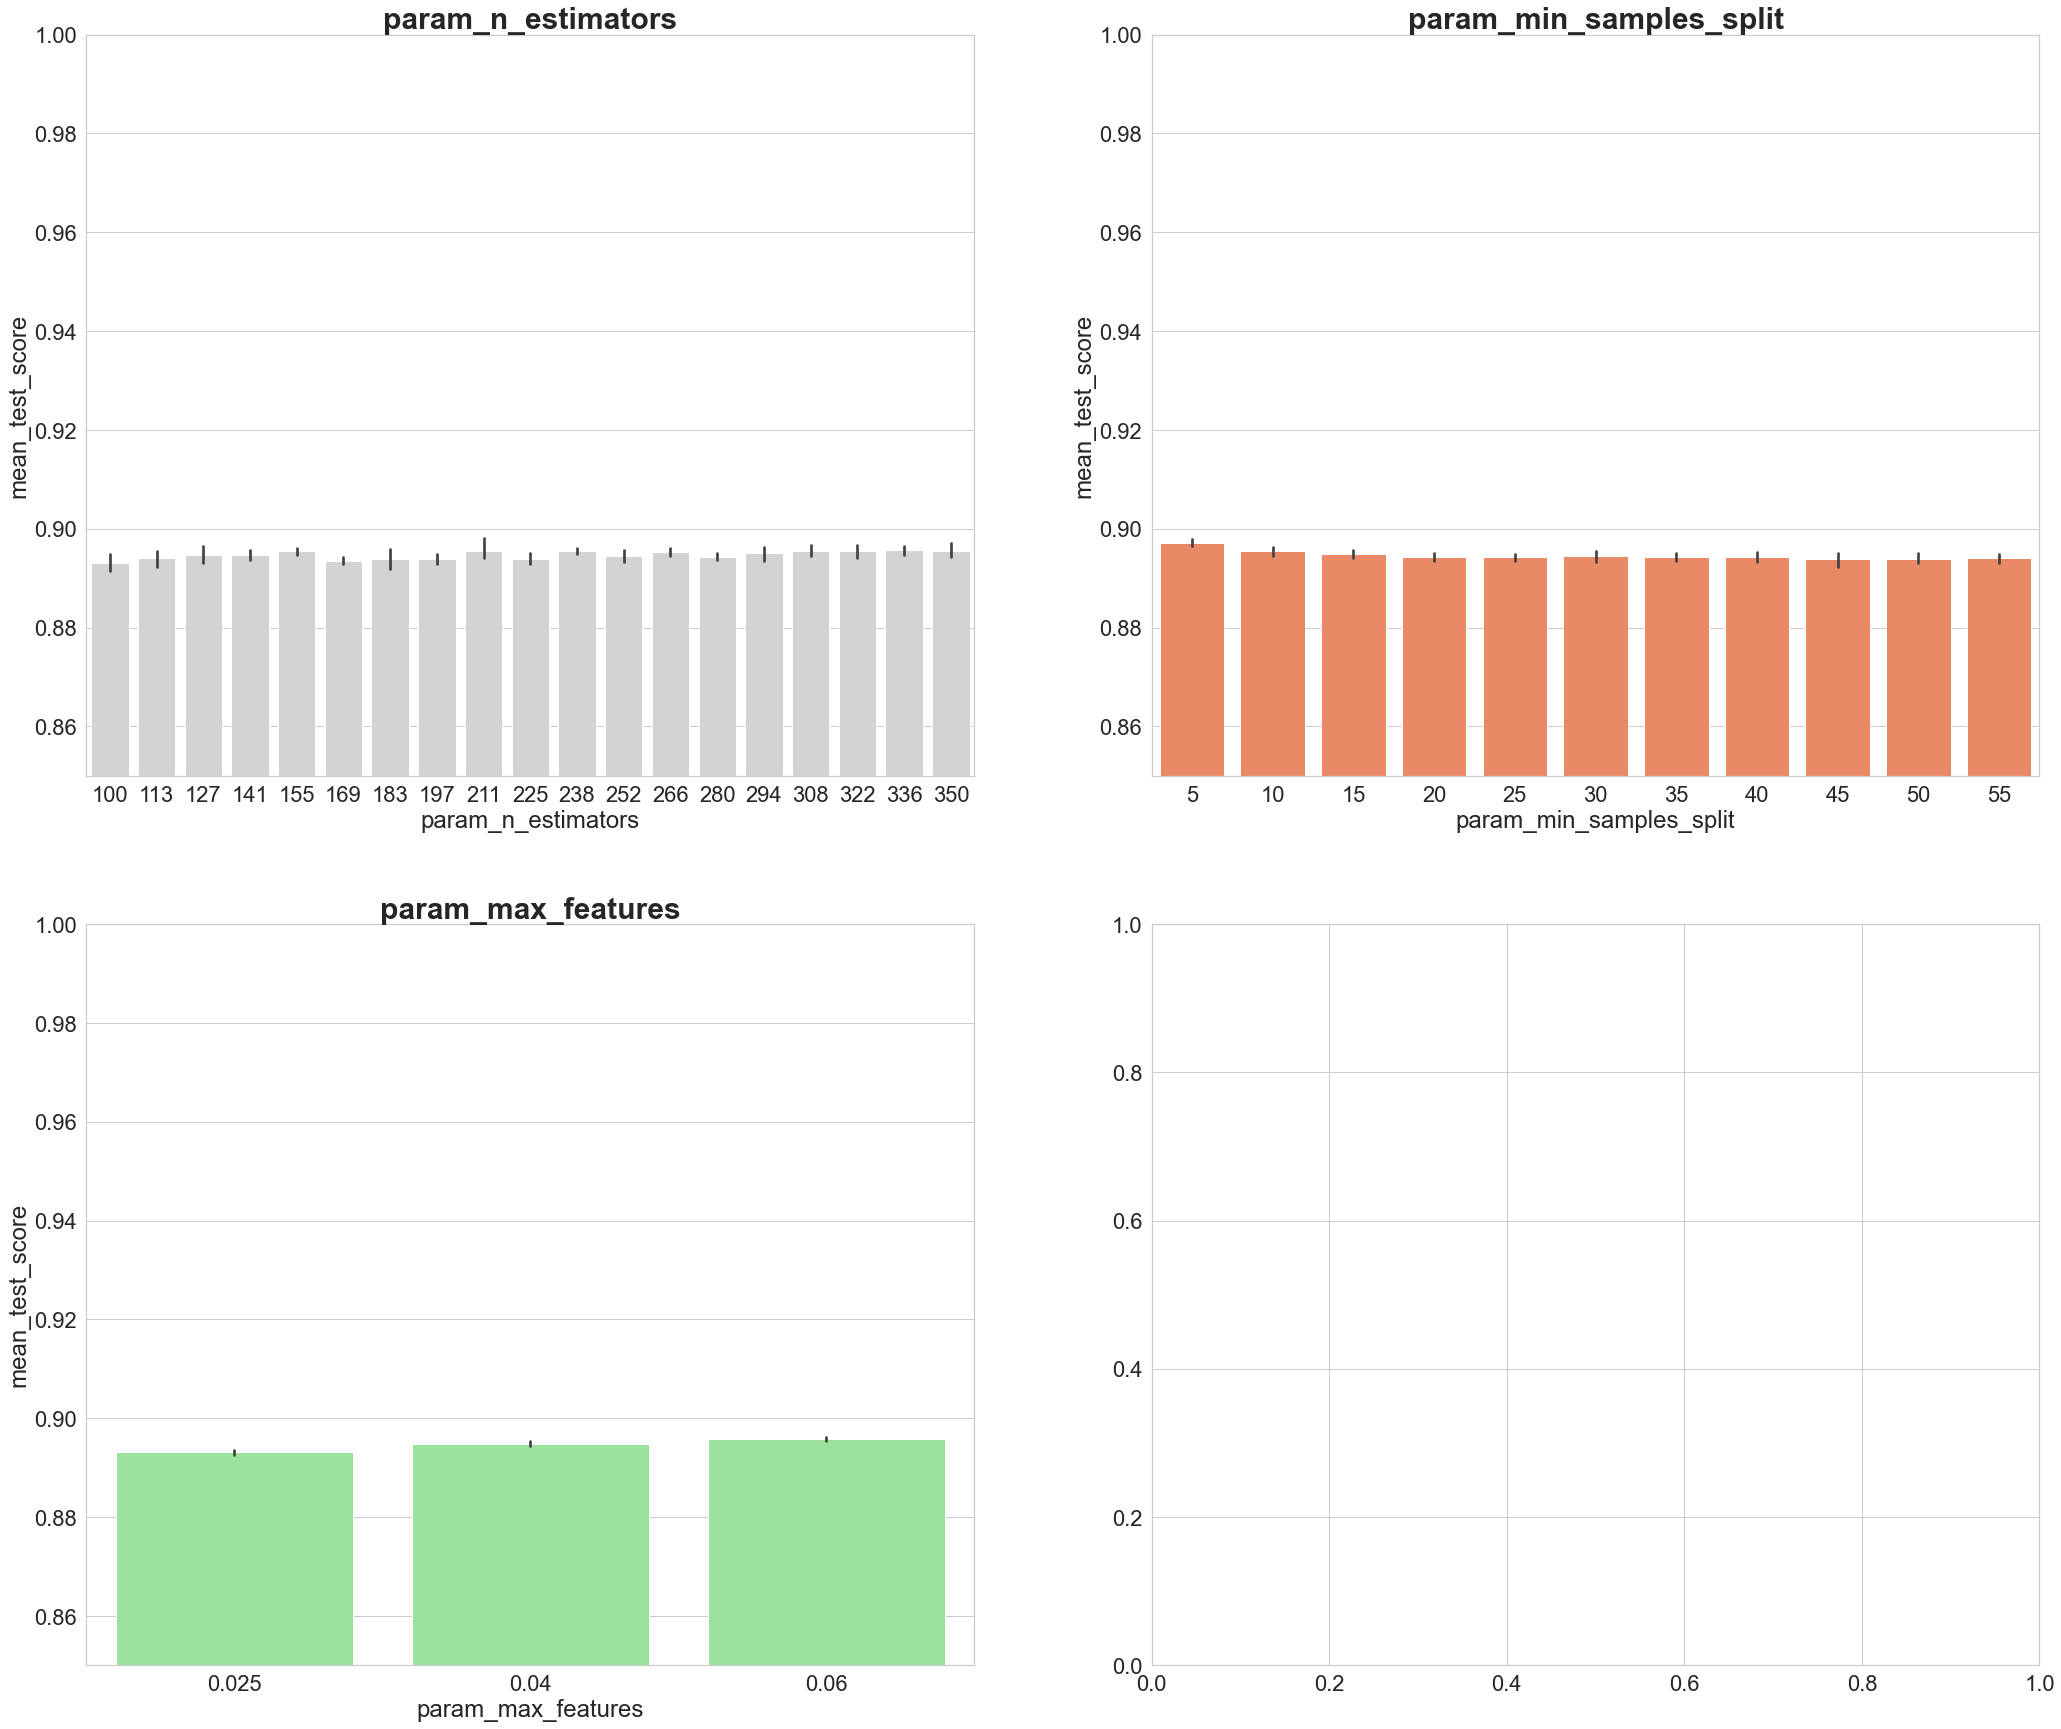

In [127]:
ShowGraphics(param_dist, rs2_df, 0.85)

=== text ===

In [118]:
ShowStatistics(rs2.best_estimator_, vectorizer)

model: RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       max_features=0.06, min_samples_split=5,
                       n_estimators=127)
vectorizer: CountVectorizer(max_features=50000, ngram_range=(1, 3))
Rows in test set: 17041
Accuracy score: 90.12%
Precision score: 90.62%


C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall score: 90.12%
                                                              precision    recall  f1-score   support

                                            ad-invoice-first       0.94      0.92      0.93      2931
                                            ad-invoice-multi       0.89      0.75      0.81       359
                                          ad-statement-first       0.98      0.99      0.98      3929
                                          ad-statement-multi       0.93      0.87      0.90       524
                                                ad-upd-first       0.90      0.96      0.93      2488
                                                ad-upd-multi       0.89      0.86      0.87       520
                                            ad-waybill-first       0.96      0.96      0.96       985
                                            ad-waybill-multi       0.96      0.76      0.85       139
                                                     rfq-AOG

C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


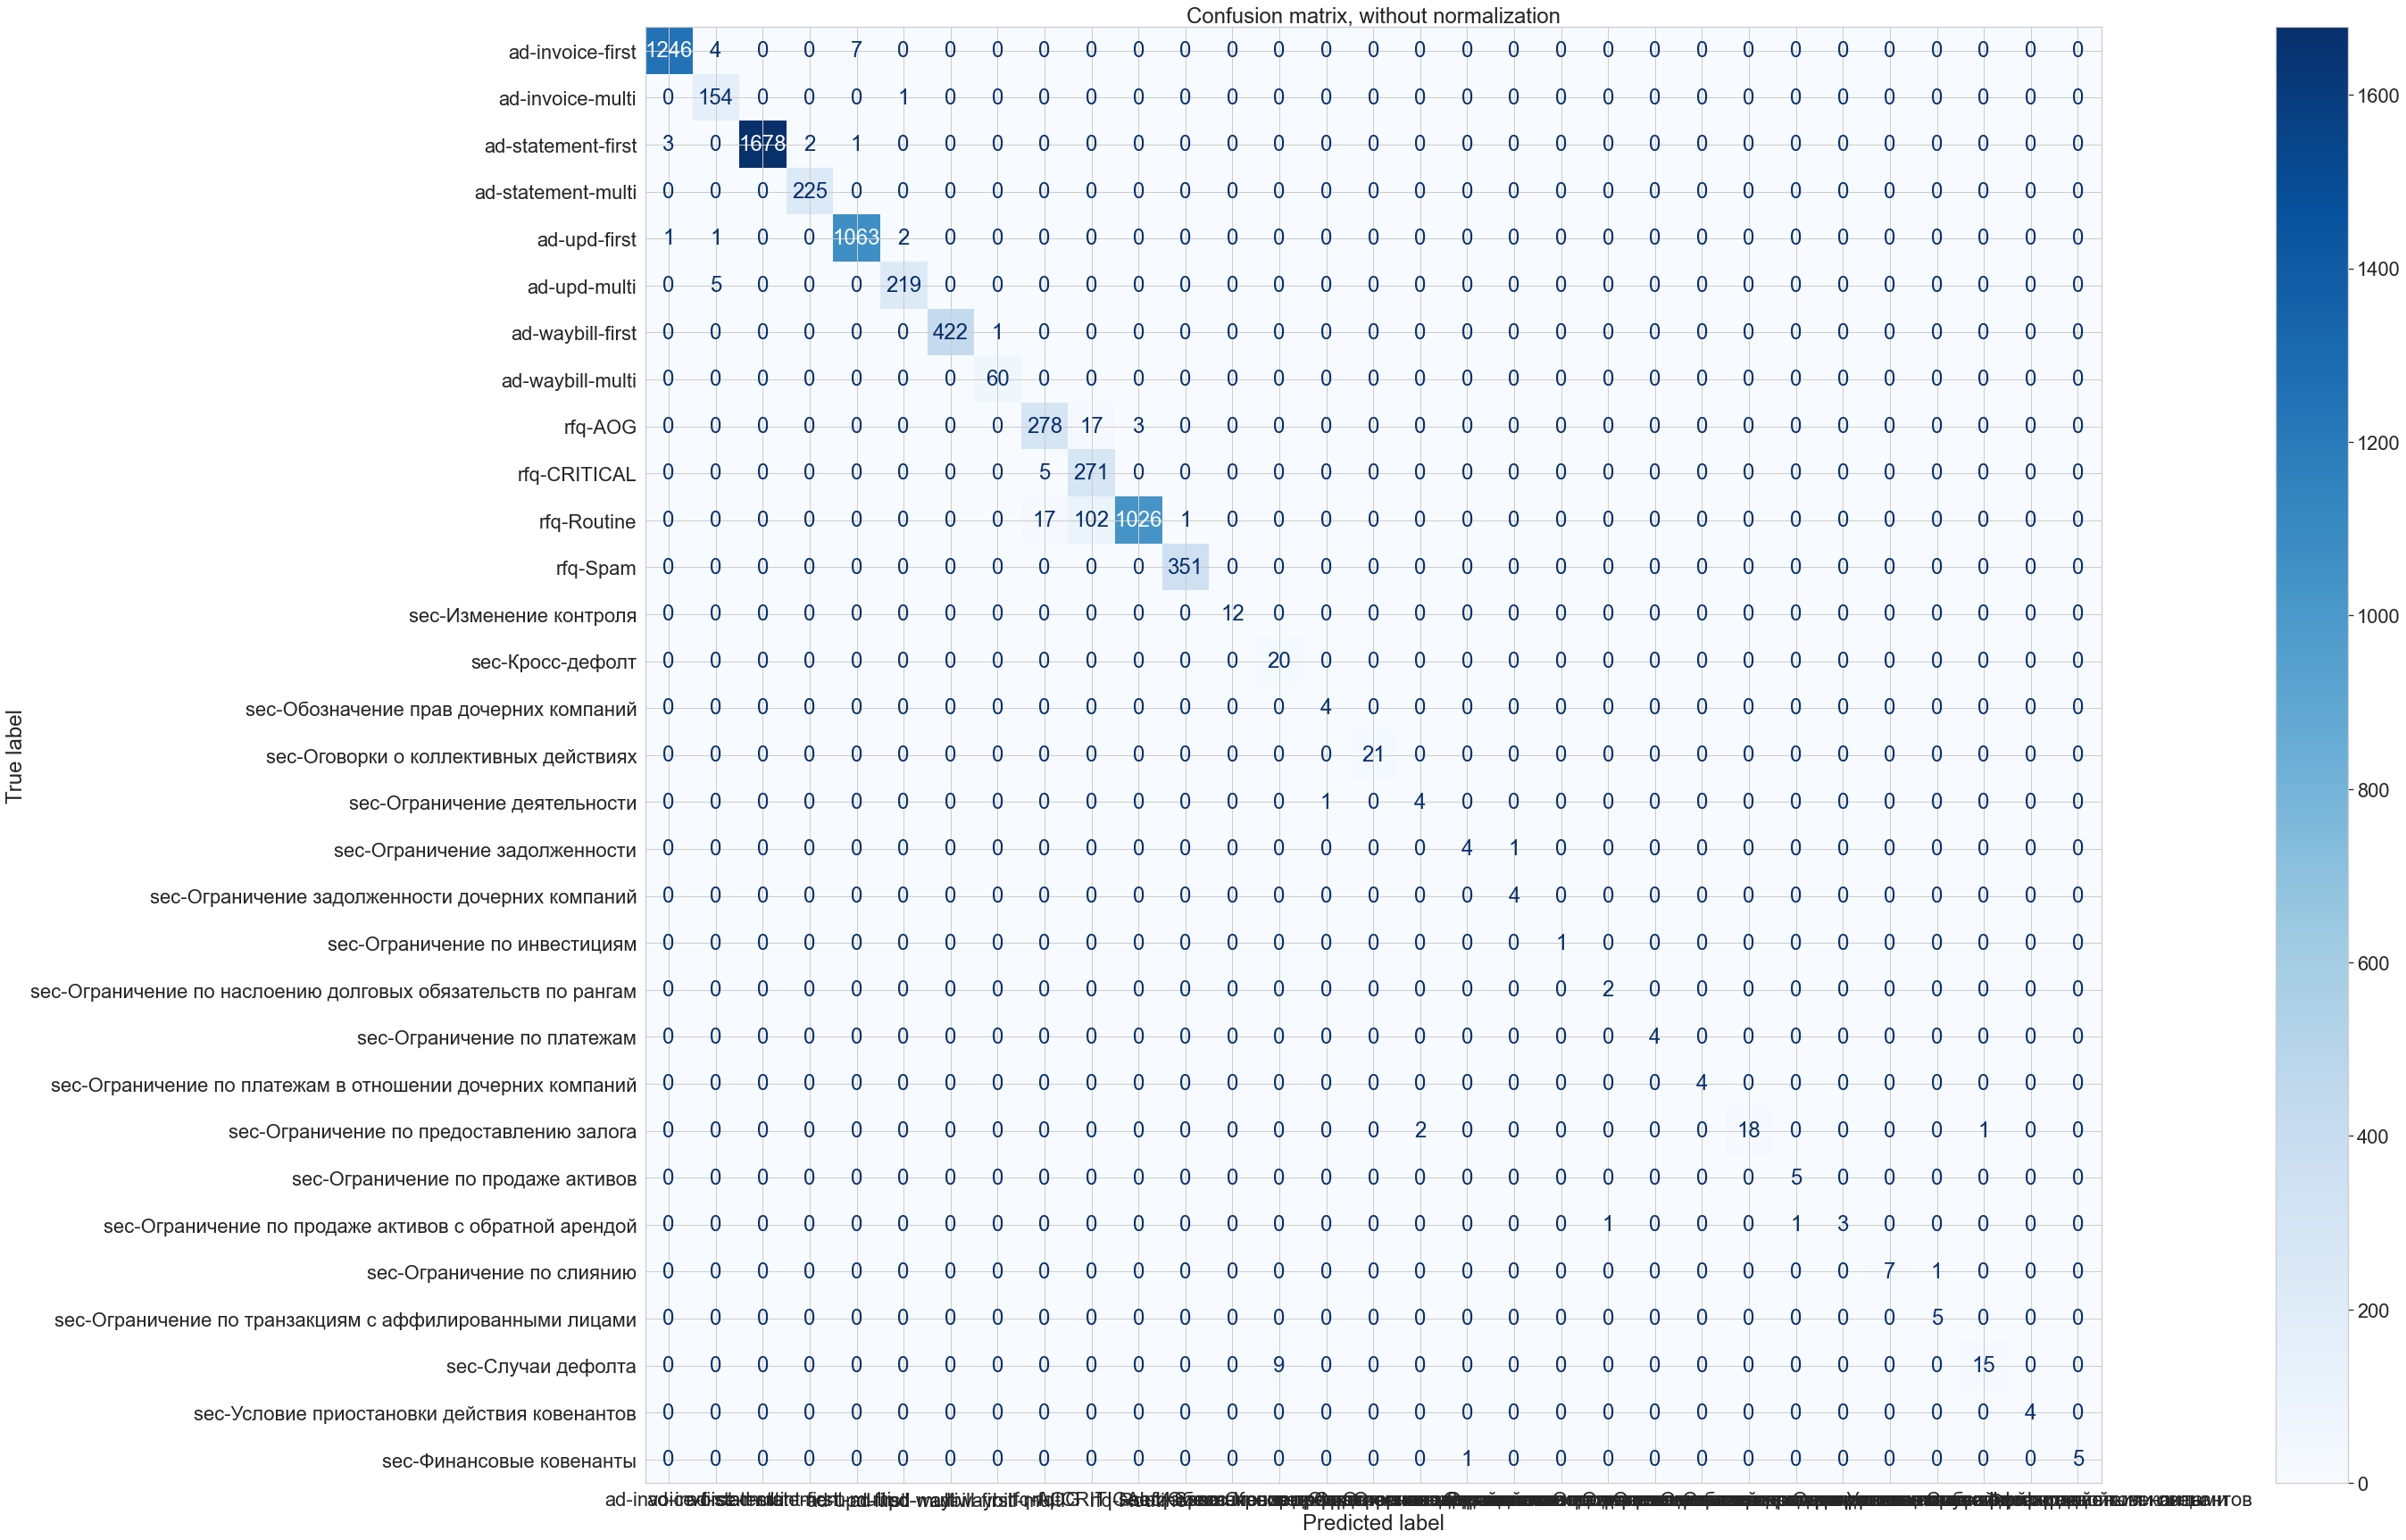

In [119]:
ShowConfusionMatrix(rs2.best_estimator_, vectorizer)

# Финальный раунд кросс валидации
На этом этапе отберем несколько параметров, которые на предыдущих этапах дали наилучшие значения точности, и переберем все комбинации этих параметров

In [120]:
def GetBestArgs(rs_df, param):
    a = rs_df.groupby(param).mean_test_score.mean().to_dict()
    srtd = [(a[key], key) for key in a.keys()]
    srtd.sort(key=lambda x: -x[0])
    srtd = [x[1] for x in srtd]
    return srtd

In [128]:
best_n_estimators = GetBestArgs(rs2_df, 'param_n_estimators')[:7]
best_min_samples_split = GetBestArgs(rs2_df, 'param_min_samples_split')[:7]
best_max_features = GetBestArgs(rs2_df, 'param_max_features')[:1]
param_dist = {
    'n_estimators' : best_n_estimators,
    'min_samples_split' : best_min_samples_split,
    'max_features' : best_max_features,
}
for key in param_dist.keys():
    print('{}: {}'.format(key, param_dist[key]))

n_estimators: [336, 308, 211, 350, 155, 238, 322]
min_samples_split: [5, 10, 15, 30, 20, 35, 40]
max_features: [0.06]


In [122]:
rf = RandomForestClassifier(min_samples_leaf=1, class_weight='balanced', bootstrap=False, max_features=0.04)
gs = GridSearchCV(rf, param_dist, cv=3, verbose=3, n_jobs=1)
gs.fit(X_train, Y_train)

Fitting 3 folds for each of 49 candidates, totalling 147 fits


C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  UserWarning,


[CV 1/3] END min_samples_split=5, n_estimators=336;, score=0.897 total time= 1.7min
[CV 2/3] END min_samples_split=5, n_estimators=336;, score=0.901 total time= 1.7min
[CV 3/3] END min_samples_split=5, n_estimators=336;, score=0.900 total time= 1.7min
[CV 1/3] END min_samples_split=5, n_estimators=308;, score=0.896 total time= 1.6min
[CV 2/3] END min_samples_split=5, n_estimators=308;, score=0.898 total time= 1.6min
[CV 3/3] END min_samples_split=5, n_estimators=308;, score=0.901 total time= 1.5min
[CV 1/3] END min_samples_split=5, n_estimators=211;, score=0.897 total time= 1.1min
[CV 2/3] END min_samples_split=5, n_estimators=211;, score=0.898 total time= 1.1min
[CV 3/3] END min_samples_split=5, n_estimators=211;, score=0.899 total time= 1.0min
[CV 1/3] END min_samples_split=5, n_estimators=350;, score=0.896 total time= 1.8min
[CV 2/3] END min_samples_split=5, n_estimators=350;, score=0.898 total time= 1.8min
[CV 3/3] END min_samples_split=5, n_estimators=350;, score=0.901 total time=

[CV 2/3] END min_samples_split=20, n_estimators=155;, score=0.892 total time=  33.0s
[CV 3/3] END min_samples_split=20, n_estimators=155;, score=0.896 total time=  32.1s
[CV 1/3] END min_samples_split=20, n_estimators=238;, score=0.890 total time=  52.1s
[CV 2/3] END min_samples_split=20, n_estimators=238;, score=0.895 total time=  50.2s
[CV 3/3] END min_samples_split=20, n_estimators=238;, score=0.896 total time=  48.7s
[CV 1/3] END min_samples_split=20, n_estimators=322;, score=0.889 total time= 1.2min
[CV 2/3] END min_samples_split=20, n_estimators=322;, score=0.895 total time= 1.1min
[CV 3/3] END min_samples_split=20, n_estimators=322;, score=0.898 total time= 1.1min
[CV 1/3] END min_samples_split=35, n_estimators=336;, score=0.889 total time= 1.1min
[CV 2/3] END min_samples_split=35, n_estimators=336;, score=0.892 total time= 1.1min
[CV 3/3] END min_samples_split=35, n_estimators=336;, score=0.893 total time= 1.0min
[CV 1/3] END min_samples_split=35, n_estimators=308;, score=0.889

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(bootstrap=False,
                                              class_weight='balanced',
                                              max_features=0.04),
             n_jobs=1,
             param_grid={'min_samples_split': [5, 10, 15, 30, 20, 35, 40],
                         'n_estimators': [336, 308, 211, 350, 155, 238, 322]},
             verbose=3)

In [123]:
gs_df = GetResultsDataFrame(gs)
gs_df.head(10)

,param_min_samples_split,param_n_estimators,mean_test_score,rank_test_score
0,5,336,0.899263,1
1,5,322,0.898717,2
2,5,308,0.898444,3
3,5,350,0.898444,3
4,5,211,0.898034,5
5,5,155,0.897488,6
6,5,238,0.897215,7
7,10,308,0.896396,8
8,10,336,0.895987,9
9,10,238,0.895850,10


In [81]:
ShowStatistics(gs.best_estimator_, vectorizer)

model: RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       max_features=0.04, min_samples_split=5,
                       n_estimators=266)
vectorizer: CountVectorizer(max_features=50000, ngram_range=(1, 3))
Rows in test set: 17041
Accuracy score: 90.1%
Precision score: 90.64%


C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall score: 90.1%
                                                              precision    recall  f1-score   support

                                            ad-invoice-first       0.94      0.92      0.93      2931
                                            ad-invoice-multi       0.88      0.75      0.81       359
                                          ad-statement-first       0.99      0.99      0.99      3929
                                          ad-statement-multi       0.97      0.90      0.93       524
                                                ad-upd-first       0.90      0.96      0.93      2488
                                                ad-upd-multi       0.89      0.82      0.85       520
                                            ad-waybill-first       0.94      0.96      0.95       985
                                            ad-waybill-multi       0.92      0.75      0.83       139
                                                     rfq-AOG 

C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [141]:
# good precision
ShowStatistics(gs.best_estimator_, vectorizer)

model: RandomForestClassifier(bootstrap=False, max_depth=160, max_features='sqrt',
                       min_samples_split=10, n_estimators=200)
vectorizer: CountVectorizer(max_features=50000, ngram_range=(1, 3))
Rows in test set: 4874
Statistics:
Precision = 77.84%; Ratio to validate = 19.86%; at confidence level = 0.8
Mean accuracy: 90.83%
Mean confidence: 89.16%
                                                              precision    recall  f1-score   support

                                            ad-invoice-first       0.95      0.94      0.94       864
                                            ad-invoice-multi       0.94      0.73      0.83       116
                                          ad-statement-first       0.98      0.99      0.99      1135
                                          ad-statement-multi       0.97      0.91      0.94       149
                                                ad-upd-first       0.92      0.96      0.94       689
                  

C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:
# write model to file
if 'models' not in os.listdir():
    os.mkdir('models')
with open('./models/doc_classifyer-model', 'wb') as f:
    pickle.dump(model, f)
with open('./models/doc_classifyer-vectorizer', 'wb') as f:
    pickle.dump(vectorizer, f)

In [82]:
# read model from file
with open('./models/doc_classifyer-model', 'rb') as f:
    model = pickle.load(f)
with open('./models/doc_classifyer-vectorizer', 'rb') as f:
    vectorizer = pickle.load(f)

In [83]:
ShowStatistics(model, vectorizer)

model: RandomForestClassifier(bootstrap=False, max_features='sqrt',
                       min_samples_split=20, n_estimators=127)
vectorizer: CountVectorizer(max_features=50000, ngram_range=(1, 3))
Rows in test set: 17041
Accuracy score: 91.64%
Precision score: 92.28%


C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall score: 91.64%


C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                              precision    recall  f1-score   support

                                            ad-invoice-first       0.97      0.93      0.95      2931
                                            ad-invoice-multi       0.96      0.74      0.84       359
                                          ad-statement-first       0.99      1.00      0.99      3929
                                          ad-statement-multi       0.99      0.93      0.96       524
                                                ad-upd-first       0.91      0.99      0.95      2488
                                                ad-upd-multi       0.92      0.87      0.90       520
                                            ad-waybill-first       0.96      0.98      0.97       985
                                            ad-waybill-multi       0.99      0.78      0.87       139
                                                     rfq-AOG       0.92      0.56

C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
